In [124]:
import numpy as np
import pandas as pd
import math
from statistics import NormalDist
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt


for i, day in enumerate([0, 1, 2, 3, 4]):
    file_name = f"./round-3-island-data-bottle/prices_round_3_day_{day}.csv"
    df_tmp = pd.read_csv(file_name, sep=';')
    df_tmp['day'] = day
    if i > 0:
        df = pd.concat([df, df_tmp])
    else:
        df = df_tmp
df = df.reset_index(drop=True)

First estimate the IV vs time with diffent strike, then fit the IV with parabolic function.

In [125]:
class BlackScholes:
    @staticmethod
    def black_scholes_call(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return spot - strike
        d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
        d2 = d1 - volatility * math.sqrt(time_to_maturity)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def black_scholes_put(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return strike - spot
        d1 = (math.log(spot / strike) + (0.5 * volatility * volatility) * time_to_maturity) / (
            volatility * math.sqrt(time_to_maturity)
        )
        d2 = d1 - volatility * math.sqrt(time_to_maturity)
        put_price = strike * NormalDist().cdf(-d2) - spot * NormalDist().cdf(-d1)
        return put_price

    @staticmethod
    def delta(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return 1
        d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
        return NormalDist().cdf(d1)

    @staticmethod
    def gamma(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return 0
        d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
        return NormalDist().pdf(d1) / (spot * volatility * math.sqrt(time_to_maturity))

    @staticmethod
    def vega(spot, strike, time_to_maturity, volatility):
        if volatility == 0:
            return 0
        d1 = (
            math.log(spot) - math.log(strike) + (0.5 * volatility * volatility) * time_to_maturity
        ) / (volatility * math.sqrt(time_to_maturity))
        # print(f"d1: {d1}")
        # print(f"vol: {volatility}")
        # print(f"spot: {spot}")
        # print(f"strike: {strike}")
        # print(f"time: {time_to_maturity}")
        return NormalDist().pdf(d1) * (spot * math.sqrt(time_to_maturity)) / 100

    @staticmethod
    def implied_volatility(
        call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-5
    ):
        if call_price + strike <= spot:
            return 0.0  # Arbitrage condition
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = BlackScholes.black_scholes_call(
                spot, strike, time_to_expiry, volatility
            )
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                return volatility
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return np.nan

    

In [126]:
STRIKES = [9500, 9750, 10000, 10250, 10500]
TIME_TO_MATURITY = 8

In [127]:
df = df[df['product'].str.startswith('VOLCANIC_ROCK')].copy().reset_index(drop=True)
df.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100.0,19.0,NaN,NaN,NaN,NaN,99.5,0.0
1,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506.0,19.0,NaN,NaN,NaN,NaN,505.5,0.0
2,0,0,VOLCANIC_ROCK_VOUCHER_9750,754.0,19.0,NaN,NaN,NaN,NaN,755.0,19.0,NaN,NaN,NaN,NaN,754.5,0.0
3,0,0,VOLCANIC_ROCK_VOUCHER_9500,1003.0,19.0,NaN,NaN,NaN,NaN,1004.0,19.0,NaN,NaN,NaN,NaN,1003.5,0.0
4,0,0,VOLCANIC_ROCK_VOUCHER_10250,273.0,19.0,NaN,NaN,NaN,NaN,274.0,19.0,NaN,NaN,NaN,NaN,273.5,0.0


In [130]:
spot = df[df['product'] == 'VOLCANIC_ROCK'].copy().reset_index(drop=True)
spot.to_csv(f'./option_data/VOLCANIC_ROCK.csv', sep=';', index=False)
for strike in STRIKES:
    # Obtain the implied volatility with BS
    option = df[df['product'] == f'VOLCANIC_ROCK_VOUCHER_{strike}'].copy().reset_index(drop=True)
    option['implied_volatility'] = option.apply(
        lambda x: BlackScholes.implied_volatility(
            x['mid_price'],
            spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
            strike,
            (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
        ),
        axis=1,
    )
    option['implied_volatility'] = option['implied_volatility'].replace(0, np.nan).ffill()
    
    print(f"Average IV for strike price {strike}: {option['implied_volatility'].mean()}")
    print(f"Std of IV for strike price {strike}: {option['implied_volatility'].std()}")
    option['delta'] = option.apply(
        lambda x: BlackScholes.delta(
            spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
            strike,
            (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
            x['implied_volatility'],
        ),
        axis=1,
    )
    option['gamma'] = option.apply(
        lambda x: BlackScholes.gamma(
            spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
            strike,
            (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
            x['implied_volatility'],
        ),
        axis=1,
    )
    option['vega'] = option.apply(
        lambda x: BlackScholes.vega(
            spot[(spot['timestamp'] == x['timestamp']) & (spot['day'] == x['day'])]['mid_price'].values[0],
            strike,
            (TIME_TO_MATURITY - x['day'] - x['timestamp'] / 1000000) / 250,
            x['implied_volatility'],
        ),
        axis=1,
    )
    option.to_csv(f'./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv', sep=';', index=False)

Average IV for strike price 9500: 0.19355174524235724
Std of IV for strike price 9500: 0.023854038230563618
Average IV for strike price 9750: 0.1503013381569803
Std of IV for strike price 9750: 0.015648350209444873
Average IV for strike price 10000: 0.13266912531876562
Std of IV for strike price 10000: 0.008528461510097198
Average IV for strike price 10250: 0.13103325151762663
Std of IV for strike price 10250: 0.009655501435304338
Average IV for strike price 10500: 0.1482092778694749
Std of IV for strike price 10500: 0.03067568627923117


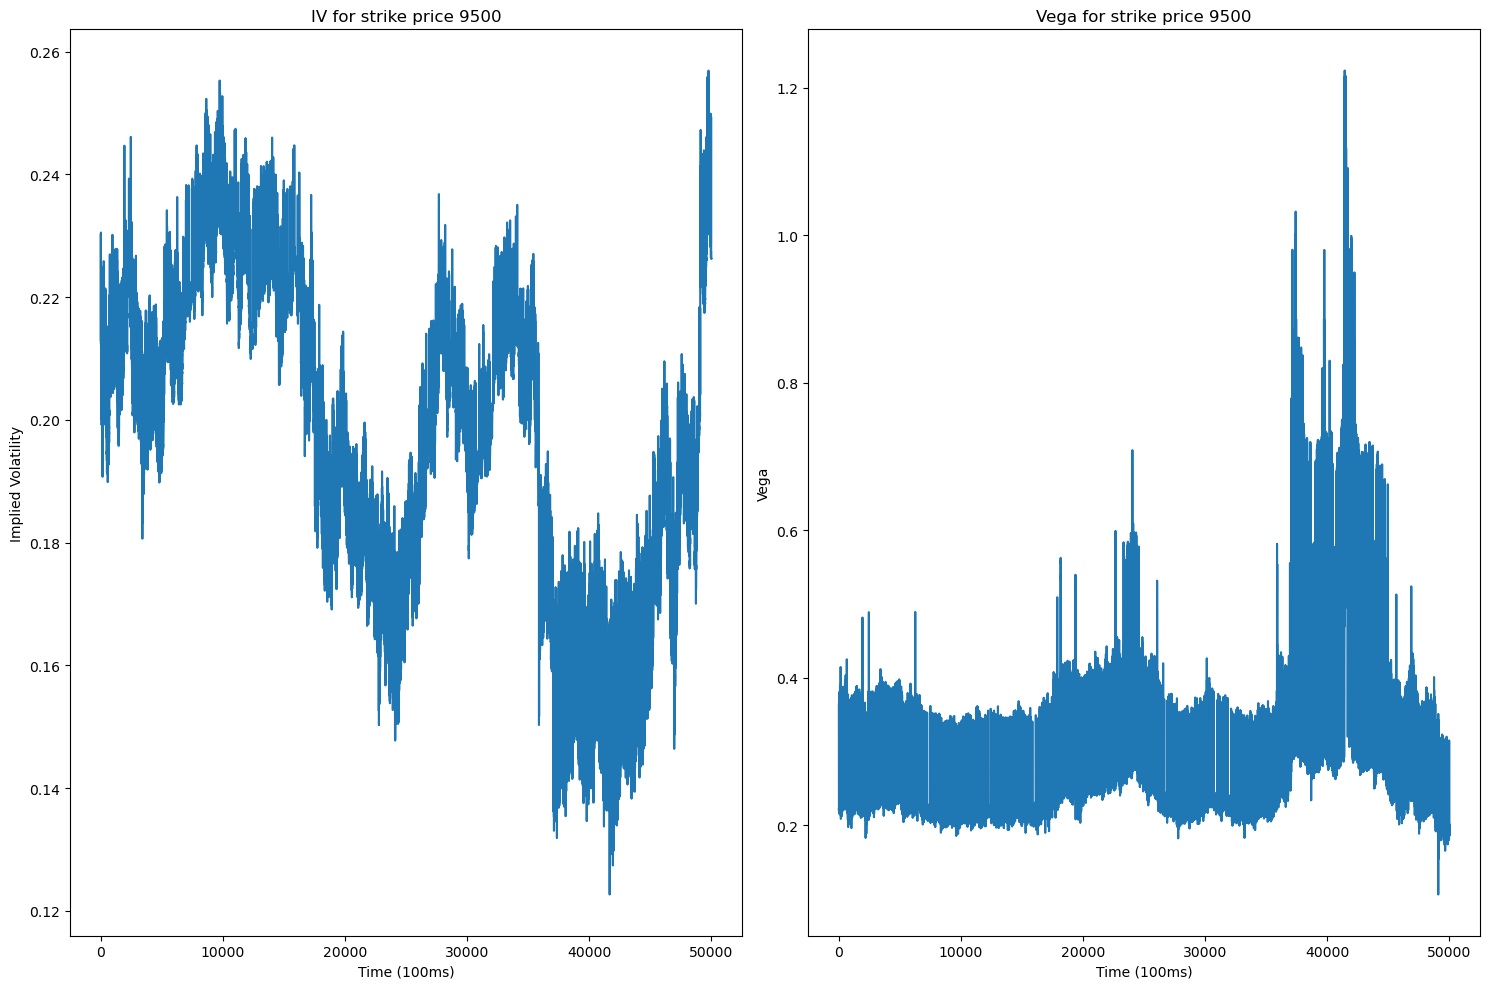

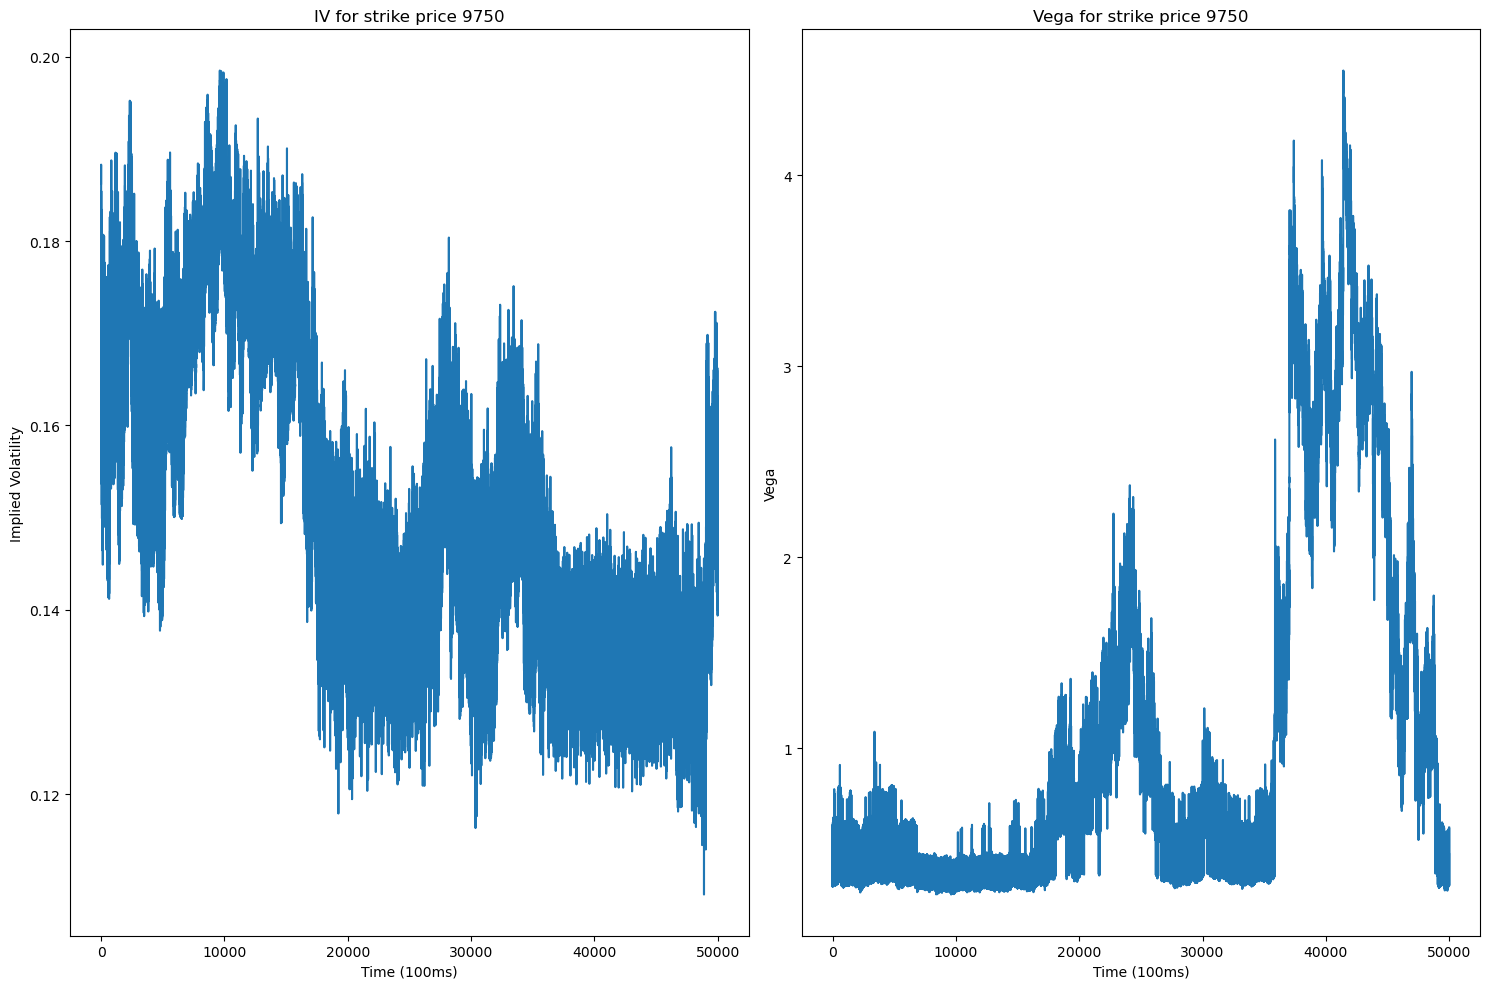

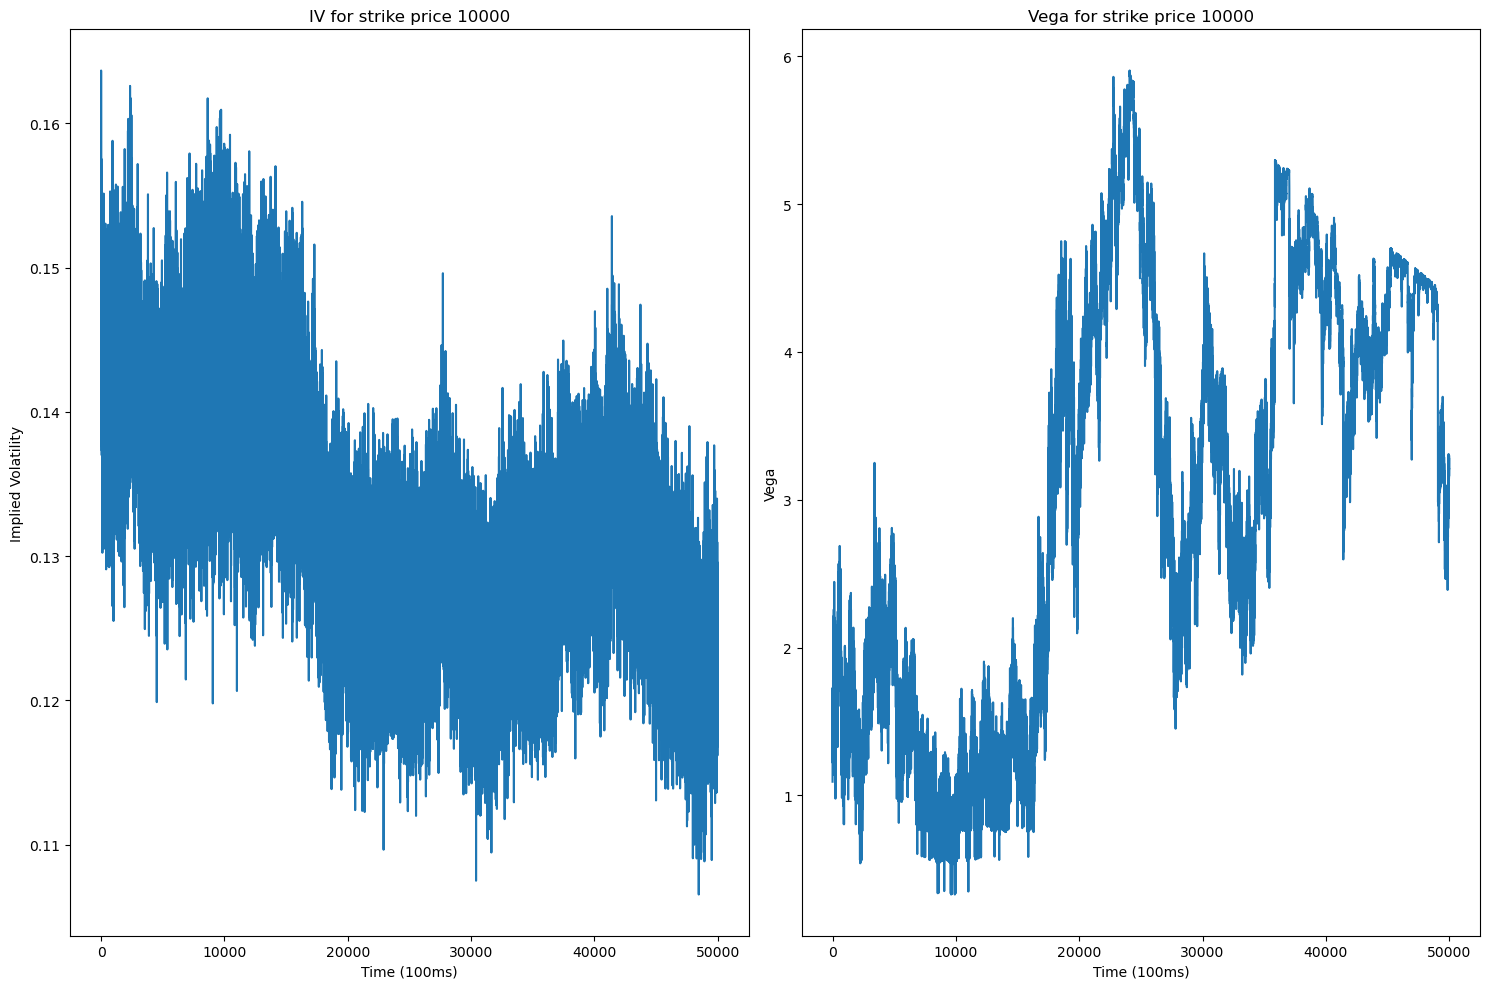

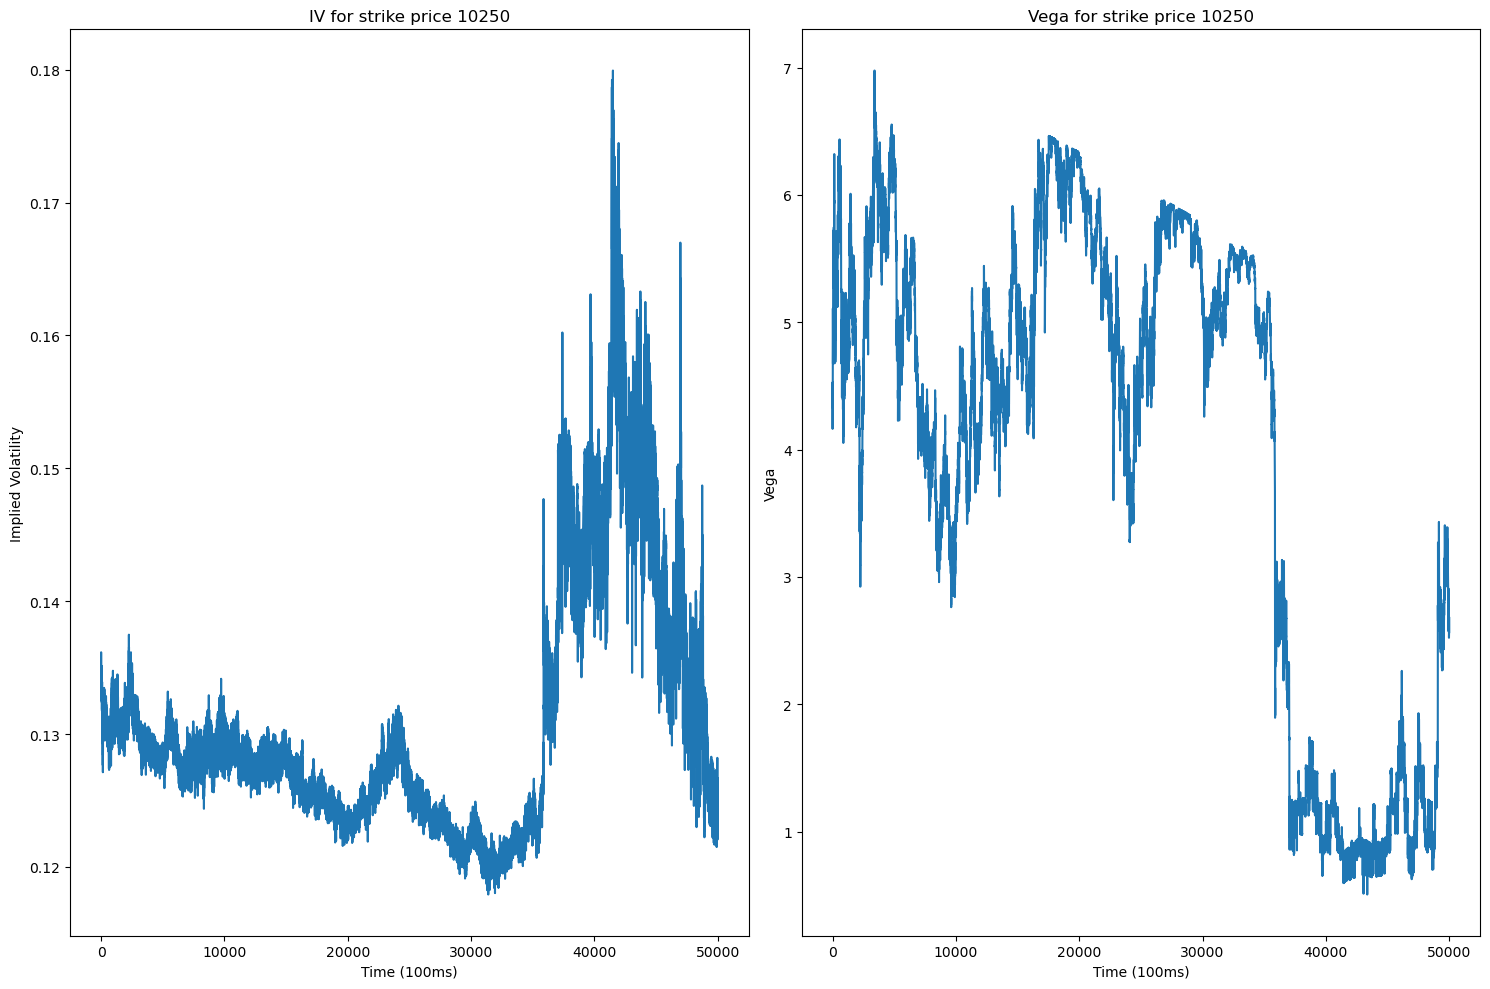

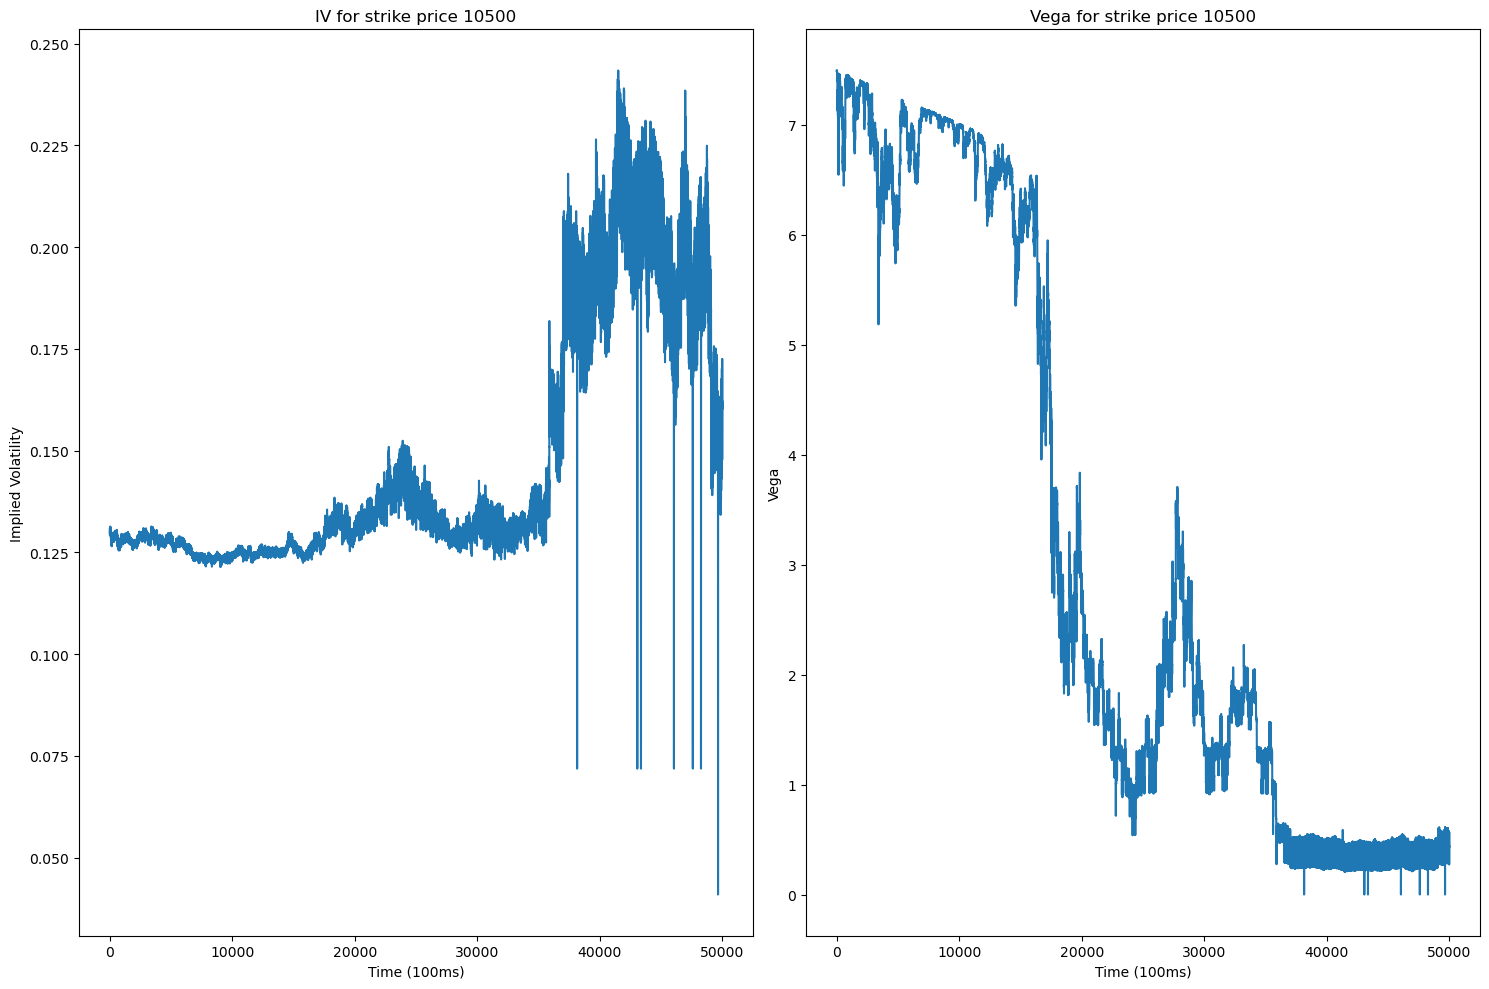

In [131]:
for strike in STRIKES:
    option = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].plot(option['implied_volatility'].replace(0, np.nan).ffill())
    ax[0].set_title("IV for strike price " + str(strike))
    ax[0].set_xlabel("Time (100ms)")
    ax[0].set_ylabel("Implied Volatility")

    ax[1].plot(option['vega'])
    ax[1].set_title("Vega for strike price " + str(strike))
    ax[1].set_xlabel("Time (100ms)")
    ax[1].set_ylabel("Vega")
    plt.tight_layout()
    plt.plot()

The IV is no-longer mean-reversion. Then try fit the smile curve with different strikes.

In [132]:
strike = STRIKES[0]
df_smile = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';', usecols=['implied_volatility'])
df_smile.rename({'implied_volatility': 'IV_' + str(strike)}, axis=1, inplace=True)
df_smile['spot_price'] = spot['mid_price']
df_smile['tte'] = (TIME_TO_MATURITY - spot['day'] - spot['timestamp'] / 1000000) / 250
df_smile['m_'+ str(strike)] = (np.log(strike) - np.log(df_smile['spot_price'])) / np.sqrt(df_smile['tte'])
for strike in STRIKES[1:]:
    df_smile['IV_'+str(strike)] = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';', usecols=['implied_volatility'])['implied_volatility']
    df_smile['m_'+ str(strike)] = (np.log(strike) - np.log(df_smile['spot_price'])) / np.sqrt(df_smile['tte'])

In [133]:
df_smile.to_csv('./option_data/IV_curve.csv', sep=';', index=False)

In [134]:
df_smile

,IV_9500,spot_price,tte,m_9500,IV_9750,m_9750,IV_10000,m_10000,IV_10250,m_10250,IV_10500,m_10500
0,0.213028,10503.0,0.032000,-0.561081,0.186255,-0.415873,0.140678,-0.274342,0.135015,-0.136306,0.130758,-0.001597
1,0.214286,10510.0,0.032000,-0.564809,0.187690,-0.419600,0.163655,-0.278068,0.135135,-0.140032,0.129949,-0.005321
2,0.214826,10513.0,0.031999,-0.566408,0.188305,-0.421198,0.151274,-0.279666,0.136155,-0.141628,0.130524,-0.006917
3,0.215634,10517.5,0.031999,-0.568803,0.179555,-0.423593,0.155980,-0.282060,0.134130,-0.144021,0.130013,-0.009309
4,0.214201,10509.5,0.031998,-0.564553,0.177985,-0.419342,0.146514,-0.277808,0.136116,-0.139768,0.130299,-0.005056
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.226213,10105.0,0.012002,-0.563546,0.163103,-0.326443,0.118310,-0.095344,0.124048,0.130049,0.162027,0.350010
49996,0.226536,10106.0,0.012002,-0.564459,0.140068,-0.327352,0.122098,-0.096249,0.123470,0.129148,0.161670,0.349113
49997,0.226536,10106.5,0.012001,-0.564920,0.153989,-0.327809,0.123980,-0.096702,0.123182,0.128699,0.161492,0.348667
49998,0.226536,10105.0,0.012001,-0.563575,0.139736,-0.326460,0.124513,-0.095349,0.124054,0.130056,0.162035,0.350028


There is abnormal iv in deep ITM option (9500 and 9750). Here I look into it to identify extremely small iv.

In [135]:
df_option = pd.read_csv("./option_data/VOLCANIC_ROCK_VOUCHER_9500.csv", sep=';')
df_option.loc[df_smile['IV_9500'] < 0.07]['mid_price'].head(10)
df_merge = pd.concat([df_option[['day', 'timestamp','mid_price', 'delta', 'vega']], df_smile[['spot_price', 'IV_9500', 'm_9500']]], axis=1)
df_merge[:50]

,day,timestamp,mid_price,delta,vega,spot_price,IV_9500,m_9500
0,0,0,1003.5,0.996010,0.222106,10503.0,0.213028,-0.561081
1,0,100,1010.5,0.996034,0.221045,10510.0,0.214286,-0.564809
2,0,200,1013.5,0.996044,0.220599,10513.0,0.214826,-0.566408
3,0,300,1018.0,0.996059,0.219931,10517.5,0.215634,-0.568803
4,0,400,1010.0,0.996032,0.221121,10509.5,0.214201,-0.564553
5,0,500,1006.5,0.996020,0.221647,10506.0,0.213574,-0.562695
6,0,600,1004.5,0.993011,0.365607,10503.5,0.230329,-0.561368
7,0,700,1003.5,0.996010,0.222097,10503.0,0.213038,-0.561105
8,0,800,997.5,0.995844,0.230191,10497.5,0.213038,-0.558180
9,0,900,995.5,0.995783,0.233190,10495.5,0.213038,-0.557119


Vega is important. When the strik is far away from the spot price, the vega can be very small ~0.2, suggesting 1% change in IV only leads to the price change of 0.2. In general, the deviation of base IV is on the order of 1%, therefore we expect vega significantly higher than 1 to gain profit purely from vol.

In [136]:
def parabolic_fit(row, strikes = STRIKES):
    mask = (row[[f"IV_{strike}" for strike in strikes]] > 0.1).values
    filtered_strikes = [strike for strike, m in zip(strikes, mask) if m]
    x = np.power(row[[f"m_{strike}" for strike in filtered_strikes]].values, 2)
    y = row[[f"IV_{strike}" for strike in filtered_strikes]].values
    cov = np.cov(x, y)
    coef = cov[0][1] / cov[0][0]
    intercept = np.mean(y) - np.mean(x) * coef
    return coef, intercept

# def parabolic_fit(row, strikes=STRIKES):
#     mask = (row[[f"IV_{strike}" for strike in strikes]] > 0.08).values
#     filtered_strikes = [strike for strike, m in zip(strikes, mask) if m]
#     if len(filtered_strikes) < 3:
#         return [np.nan, np.nan, np.nan]
#     x = row[[f"m_{strike}" for strike in filtered_strikes]].values
#     y = row[[f"IV_{strike}" for strike in filtered_strikes]].values
#     coef_ = np.polyfit(x, y, 2)
#     return coef_.tolist()
for strike in STRIKES:
    df_smile[f"IV_{strike}"] = df_smile[f"IV_{strike}"].replace(0, np.nan).ffill()
df_smile['parabolic_coef'] = df_smile.apply(parabolic_fit, axis=1)
df_smile['IV_ATM'] = df_smile['parabolic_coef'].apply(lambda x: x[1])
# df_smile['linear_coef'] = df_smile['parabolic_coef'].apply(lambda x: x[1])
df_smile['parabolic_coef'] = df_smile['parabolic_coef'].apply(lambda x: x[0])

<Axes: >

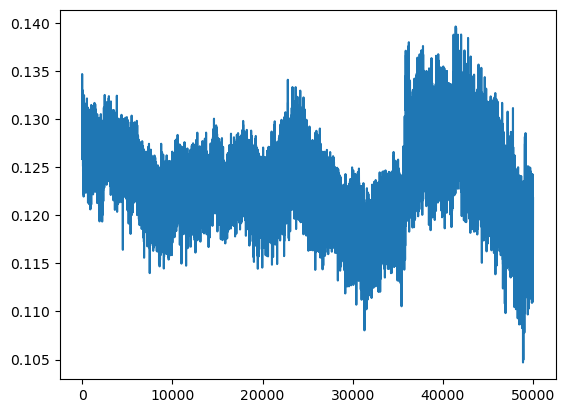

In [137]:
df_smile['IV_ATM'].plot()

<Axes: >

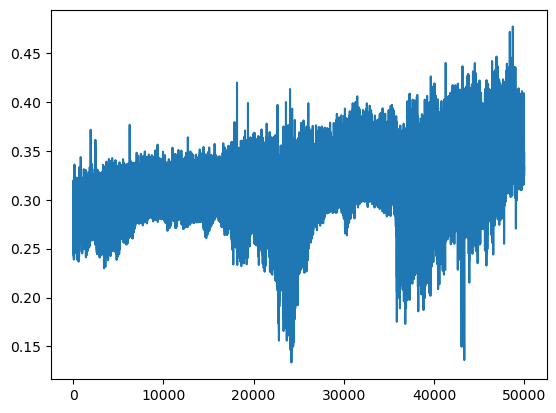

In [138]:
df_smile['parabolic_coef'].plot()

In [139]:
df_smile.to_csv("./option_data/IV_curve.csv", sep=';', index=False)

Verify result

In [140]:
idx = 2046
strike = 9500
day = 1
df = pd.read_csv(f"./round-3-island-data-bottle/prices_round_3_day_{day}.csv", sep=';')
spot = df[(df['product'] == 'VOLCANIC_ROCK') & (df['day'] == day)].copy().reset_index(drop=True)
option =  df[(df['product'] == f'VOLCANIC_ROCK_VOUCHER_{strike}') & (df['day'] == day)].copy().reset_index(drop=True)
call_price = option.loc[option['day'] == day, 'mid_price'].reset_index(drop=True).iloc[idx]
spot = spot.loc[spot['day'] == day, 'mid_price'].reset_index(drop=True).iloc[idx]
time_to_maturity = (TIME_TO_MATURITY - day - option['timestamp'].iloc[idx] / 1000000) / 250

iv = BlackScholes.implied_volatility(call_price, spot, strike, time_to_maturity)
print(f'Theoretical: {iv}')
df = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
print(f'Practical: {df.loc[df['day'] == day, 'implied_volatility'].reset_index(drop=True).iloc[idx]}')

Theoretical: 0.22321458816528317
Practical: 0.2232145881652831


Time series analysis of base IV.

In [141]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# adf test
adf_test = adfuller(df_smile['IV_ATM'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")


ADF Statistic: -3.9388574376119445
p-value: 0.0017667775377141512


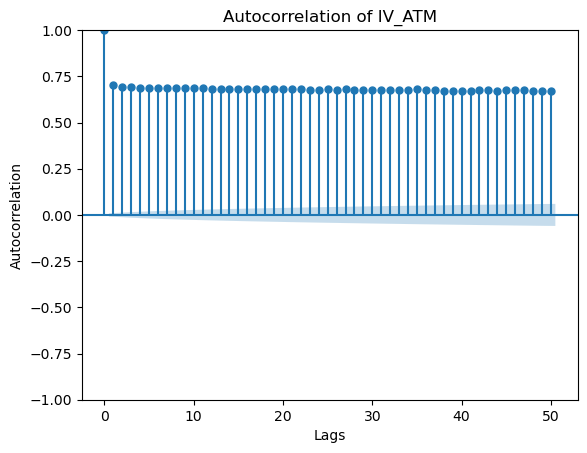

In [142]:
# Plot the autocorrelation of df_smile['IV_ATM']
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df_smile['IV_ATM'], lags=50)
plt.title('Autocorrelation of IV_ATM')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

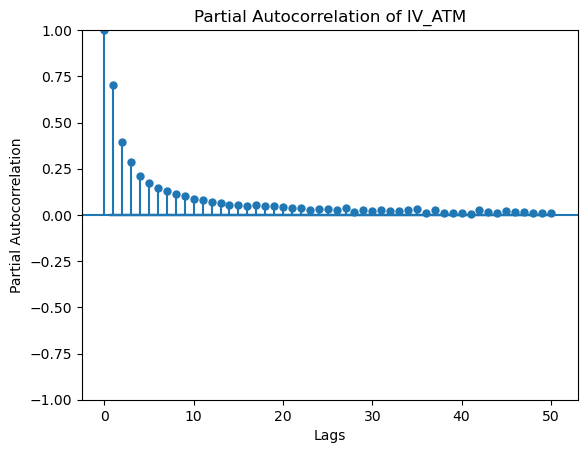

In [143]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_smile['IV_ATM'], lags=50, alpha=0.01)  
plt.title('Partial Autocorrelation of IV_ATM')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

First order difference

In [144]:
df_smile['IV_ATM_DIFF'] = df_smile['IV_ATM'].diff()

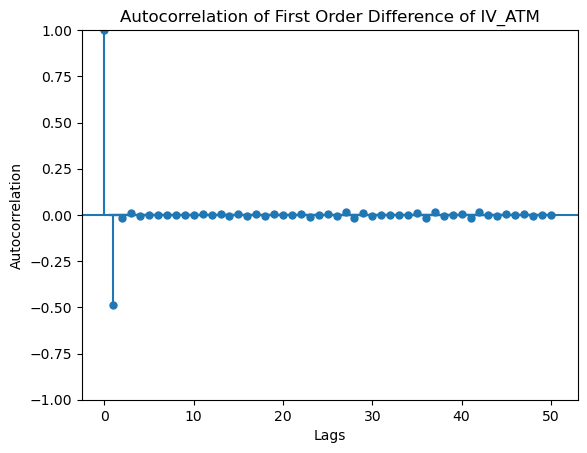

In [145]:
plot_acf(df_smile['IV_ATM_DIFF'].dropna(), lags=50)
plt.title('Autocorrelation of First Order Difference of IV_ATM')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

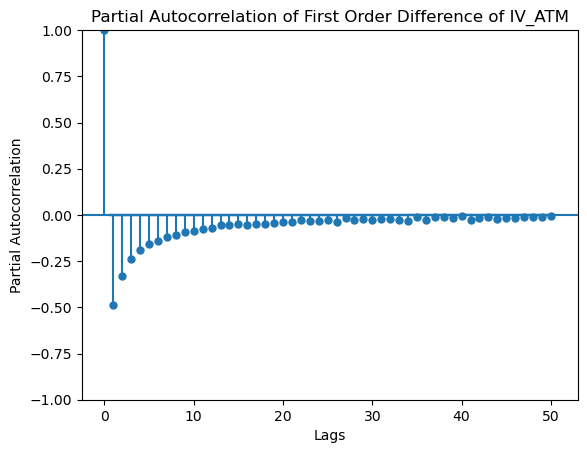

In [146]:
plot_pacf(df_smile['IV_ATM_DIFF'].dropna(), lags=50)
plt.title('Partial Autocorrelation of First Order Difference of IV_ATM')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

Strong mean-reversion suggested by ~-0.5 autocorrelation of order 1.

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Regress df_smile['IV_ATM_DIFF'] on its lagged values
X = df_smile['IV_ATM_DIFF'].shift(1).dropna()
y = df_smile['IV_ATM_DIFF'].dropna()[1:]  # Drop the first value to align with X

# Train-test split
train_size = int(len(X) * 0.8)

model = LinearRegression()
model.fit(X.values[:train_size].reshape(-1, 1), y.values[:train_size].reshape(-1, 1))
print(model.coef_, model.intercept_)

[[-0.48451225]] [-2.48247246e-07]


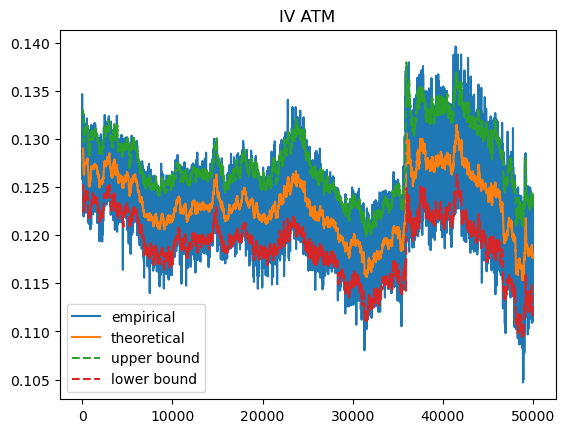

In [148]:
theo = df_smile['IV_ATM'].rolling(100).mean()
std = df_smile['IV_ATM'].rolling(100).std()
thres = 2
plt.plot(df_smile['IV_ATM'], label='empirical')
plt.plot(theo, label='theoretical')
plt.plot(theo + thres * std, label='upper bound', linestyle='--')
plt.plot(theo - thres * std, label='lower bound', linestyle='--')
plt.title('IV ATM')
plt.legend()

In [149]:
print(r2_score(y[train_size:], model.predict(X.values[train_size:].reshape(-1, 1))))

0.23548698338550933


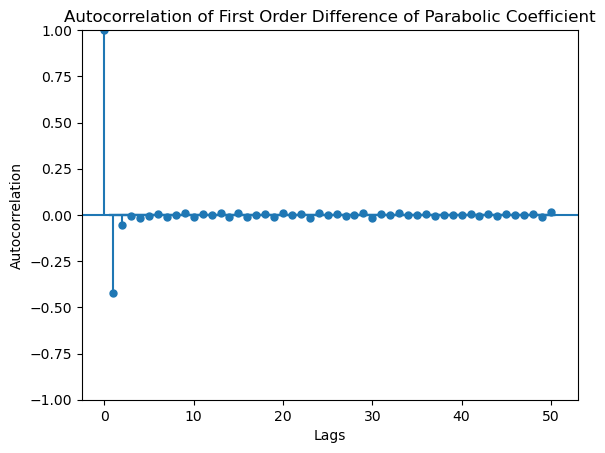

In [150]:
plot_acf(df_smile['parabolic_coef'].diff().dropna(), lags=50)
plt.title('Autocorrelation of First Order Difference of Parabolic Coefficient')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

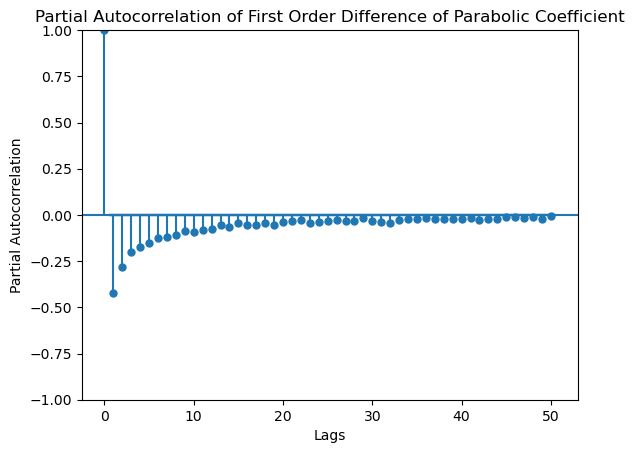

In [151]:
plot_pacf(df_smile['parabolic_coef'].diff().dropna(), lags=50)
plt.title('Partial Autocorrelation of First Order Difference of Parabolic Coefficient')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [152]:
X = df_smile['parabolic_coef'].diff().shift(1).dropna()
y = df_smile['parabolic_coef'].diff().dropna()[1:]  # Drop the first value to align with X

# Train-test split
train_size = int(len(X) * 0.8)

model = LinearRegression()
model.fit(X.values[:train_size].reshape(-1, 1), y.values[:train_size].reshape(-1, 1))
print(model.coef_, model.intercept_)

[[-0.40254741]] [2.00810641e-06]


In [153]:
print(r2_score(y[train_size:], model.predict(X.values[train_size:].reshape(-1, 1))))

0.21694332248213832


Predict the price of options

In [154]:
spot = pd.read_csv("./option_data/VOLCANIC_ROCK.csv", sep=';')
option_prices = dict()
for strike in STRIKES:
    option_prices[strike] = (pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')['mid_price'].values)
spot_price = spot['mid_price'].values
tte = (TIME_TO_MATURITY - spot['day'].values - spot['timestamp'].values / 1000000) / 250

In [155]:
iv_curve = pd.read_csv("./option_data/IV_curve.csv", sep=';')
coef = iv_curve['parabolic_coef'].copy()
base_iv = iv_curve['IV_ATM'].copy()

In [156]:
strike = 10500
base_iv_diff = base_iv.diff()
coef_diff = coef.diff()

predicted_base_iv = -0.5 * base_iv_diff + base_iv
predicted_coef = -0.5 * coef_diff + coef

tte -= 1 / 2500000
x2 = np.log(strike / spot_price) ** 2 / tte
predicted_iv = predicted_base_iv + predicted_coef * x2
d1 = (np.log(spot_price / strike) + 0.5 * np.power(predicted_iv, 2) * tte) / predicted_iv / np.sqrt(tte)
d2 = d1 - predicted_iv * np.sqrt(tte)
predicted_price = np.array([spot_price[i] * NormalDist().cdf(x1) - strike * NormalDist().cdf(x2) for i, (x1, x2) in enumerate(zip(d1.values, d2.values))])

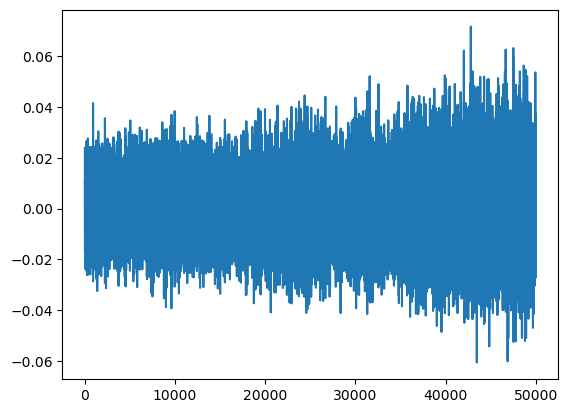

In [157]:
plt.plot(predicted_base_iv[1:-1] / base_iv[2:] - 1, label='Prediction Error')
plt.show()

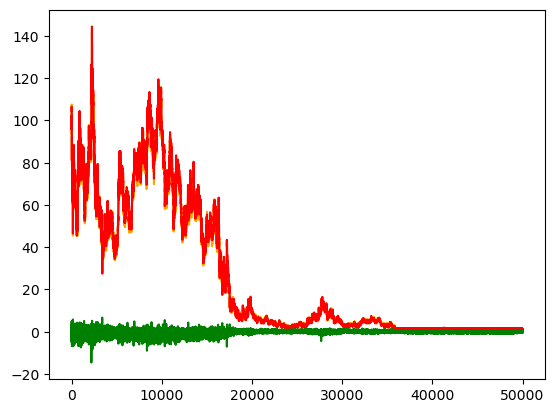

In [158]:
plt.plot(predicted_price[1:-1], label='Predicted Price', color='orange')
plt.plot(option_prices[strike][2:], label='Actual Price', color='red')
plt.plot(predicted_price[1:-1] - option_prices[strike][2:], label='Prediction Error', color='green')
plt.show()

The price itself is hard to predict. We try using the arbitrage opinion. First try to find out the trend term in base iv. Then set threshold for volatility mean-reversion.

In [159]:
np.corrcoef(np.arange(len(df_smile)), df_smile['IV_ATM'].values)[0][1]

-0.1173083186832935

In [160]:
np.corrcoef(np.arange(len(df_smile)), df_smile['parabolic_coef'].values)[0][1]

0.5988390985802969

In [161]:
model = LinearRegression()
x = np.arange(len(df_smile))
y = df_smile['IV_ATM'].values
# Filter out extreme values
mask = (y > 0.113)
x_filtered = x[mask].reshape(-1, 1)
y_filtered = y[mask].reshape(-1, 1)
model.fit(x_filtered, y_filtered)
print(model.coef_[0], model.intercept_)
print(r2_score(df_smile['IV_ATM'].values, model.predict(np.arange(len(df_smile)).reshape(-1, 1))))

[-2.75272587e-08] [0.12399485]
0.013341040137316074


In [162]:
coef_model = LinearRegression()
x = np.arange(len(df_smile))
y = df_smile['parabolic_coef'].values
coef_model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
print(coef_model.coef_[0], coef_model.intercept_)
print(r2_score(df_smile['parabolic_coef'].values, coef_model.predict(np.arange(len(df_smile)).reshape(-1, 1))))

[1.50673713e-06] [0.26198043]
0.35860826598846274


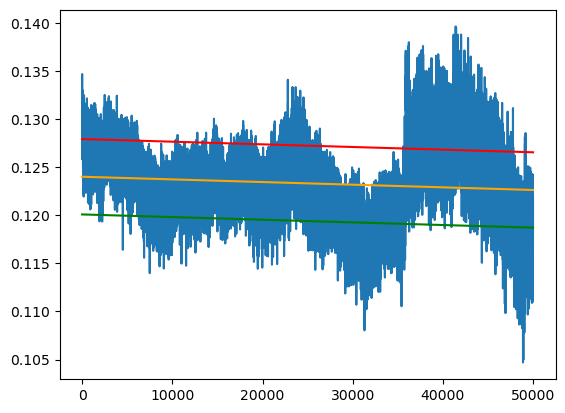

In [163]:
thres = 1
theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
upper = theo + thres * np.std(df_smile['IV_ATM'].values)
lower = theo - thres * np.std(df_smile['IV_ATM'].values)

# plot
plt.plot(df_smile['IV_ATM'].values, label='IV_ATM')
plt.plot(theo, label='Theoretical IV', color='orange')
plt.plot(upper, label='Upper Bound', color='red')
plt.plot(lower, label='Lower Bound', color='green')

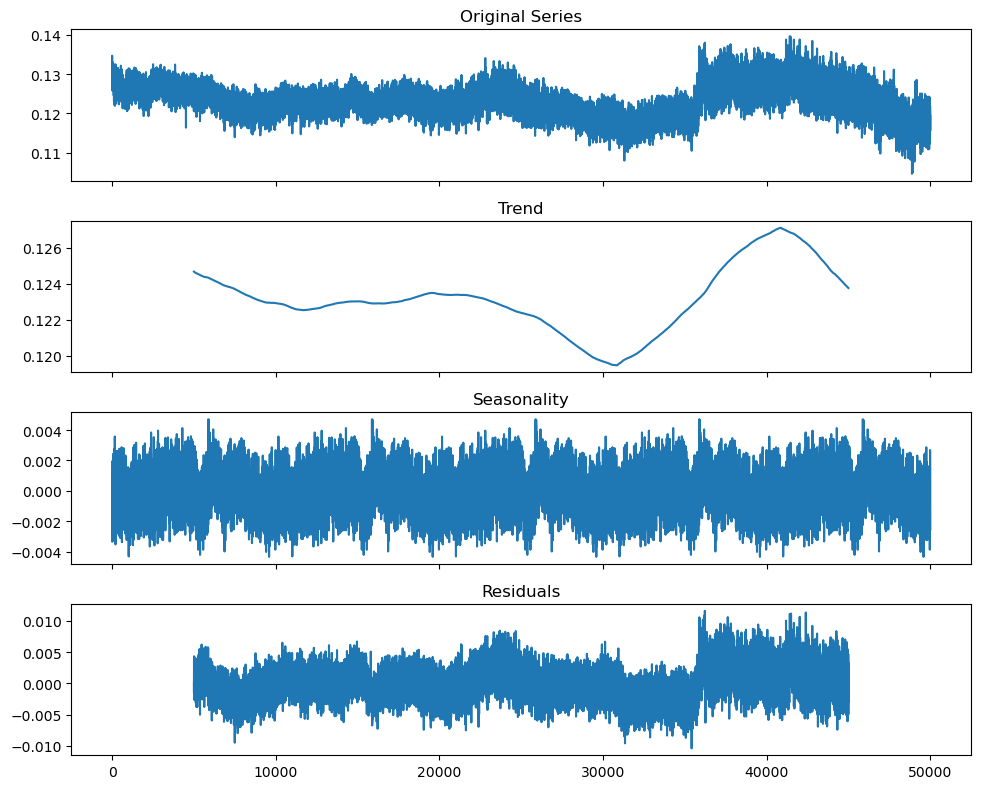

In [164]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt

# Fit an ARIMA model to the IV_ATM series
arima_model = ARIMA(df_smile['IV_ATM'], order=(0, 1, 1))
arima_result = arima_model.fit()

# Decompose the series using seasonal_decompose
decomposition = seasonal_decompose(df_smile['IV_ATM'], model='additive', period=10000)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
axes[0].plot(df_smile['IV_ATM'], label='Original')
axes[0].set_title('Original Series')
axes[1].plot(decomposition.trend, label='Trend')
axes[1].set_title('Trend')
axes[2].plot(decomposition.seasonal, label='Seasonality')
axes[2].set_title('Seasonality')
axes[3].plot(decomposition.resid, label='Residuals')
axes[3].set_title('Residuals')
plt.tight_layout()
plt.show()

In [165]:
np.std(df_smile['IV_ATM'].values)

0.003916807102924095

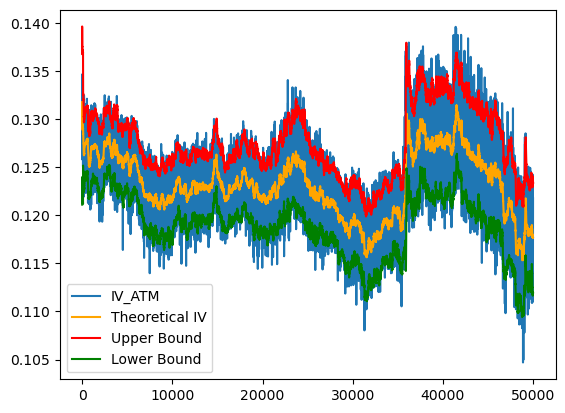

In [166]:
thres = 2
window = 100
theo = df_smile['IV_ATM'].rolling(window=window, min_periods=1).mean()
# theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
rolling_std = df_smile['IV_ATM'].rolling(window=window).std()
rolling_std = rolling_std.fillna(np.std(df_smile['IV_ATM'].values))
upper = theo + thres * rolling_std
lower = theo - thres * rolling_std

# plot
plt.plot(df_smile['IV_ATM'].values, label='IV_ATM')
plt.plot(theo, label='Theoretical IV', color='orange')
plt.plot(upper, label='Upper Bound', color='red')
plt.plot(lower, label='Lower Bound', color='green')
plt.legend()
plt.show()

Calculate the theoretical IV for single options

In [167]:
parabolic_coef = df_smile['parabolic_coef'].mean()
print(f"parabolic_coef: {parabolic_coef}")
# parabolic_coef = df_smile['parabolic_coef'].rolling(100).mean()
theo_iv_per_option = dict()
for strike in STRIKES:
    x2 = np.log(strike / spot_price) ** 2 / tte
    theo_iv_per_option[strike] = x2 * parabolic_coef + theo

parabolic_coef: 0.2996481021351207


last ewma: 0.21230917829740162, last std: 0.02300917758685847


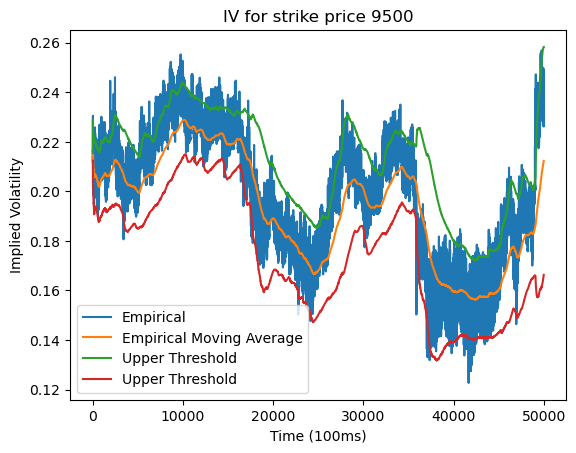

last ewma: 0.14352821335885646, last std: 0.011414450922073101


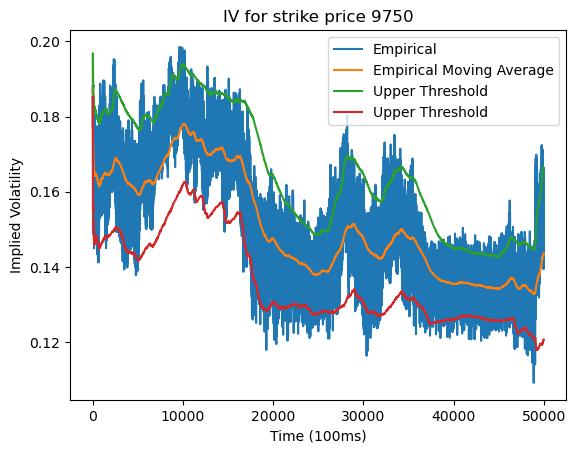

last ewma: 0.1235421801445634, last std: 0.004797987629940709


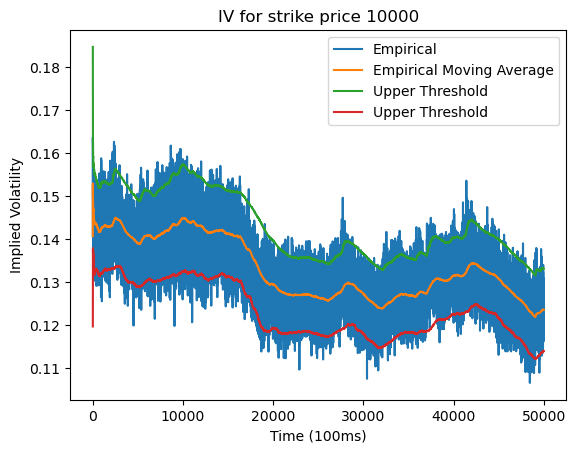

last ewma: 0.12886930829522938, last std: 0.005683749897760977


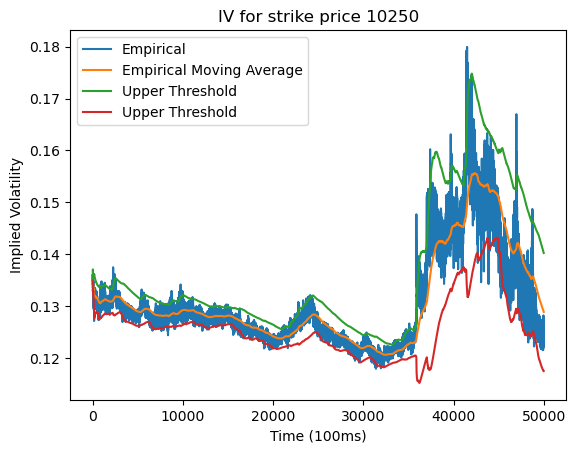

last ewma: 0.17169285294317063, last std: 0.02090723882485036


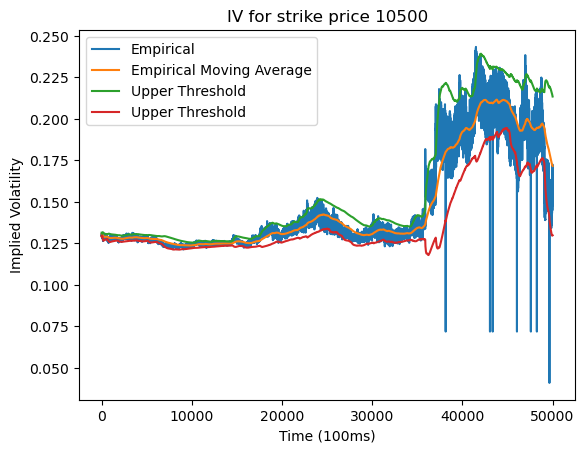

In [173]:
thres = 2
for strike in STRIKES:
    option = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
    fig, ax = plt.subplots()
    option['implied_volatility'] = option['implied_volatility'].replace(0, np.nan).ffill()
    ewma = option['implied_volatility'].ewm(alpha=0.001).mean()
    std = option['implied_volatility'].ewm(alpha=0.001).std()
    ax.plot(option['implied_volatility'], label = "Empirical")
    ax.plot(ewma, label="Empirical Moving Average")
    # ax.plot(theo_iv_per_option[strike].rolling(100).mean().shift(), label="Theoretical")
    # ax.plot(theo_iv_per_option[strike] + thres * option['implied_volatility'].replace(0, np.nan).ffill().rolling(100).std(), label="Upper bound")
    # ax.plot(theo_iv_per_option[strike] - thres * option['implied_volatility'].replace(0, np.nan).ffill().rolling(100).std(), label="Lower bound")
    ax.plot(ewma + thres * std, label="Upper Threshold")
    ax.plot(ewma - thres * std, label="Upper Threshold")
    ax.legend()
    ax.set_title("IV for strike price " + str(strike))
    ax.set_xlabel("Time (100ms)")
    ax.set_ylabel("Implied Volatility")
    print(f"last ewma: {ewma.iloc[-1]}, last std: {std.iloc[-1]}")
    plt.show()

In [115]:
rtn = spot['mid_price'].apply(np.log).diff(1000).dropna()
np.std(rtn) * np.sqrt(2500)

0.2768836166368569

<Axes: >

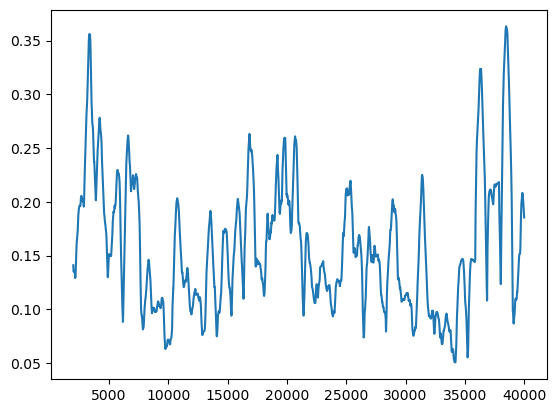

In [117]:
(np.sqrt(2500) * rtn.rolling(1000).std()).plot()

Use simultaneous coefficient instead

In [42]:
theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
theo_iv_per_option = dict()
for strike in STRIKES:
    x = np.log(strike / spot_price) ** 2 / tte
    theo_iv_per_option[strike] = x2 * df_smile['parabolic_coef'].values + theo

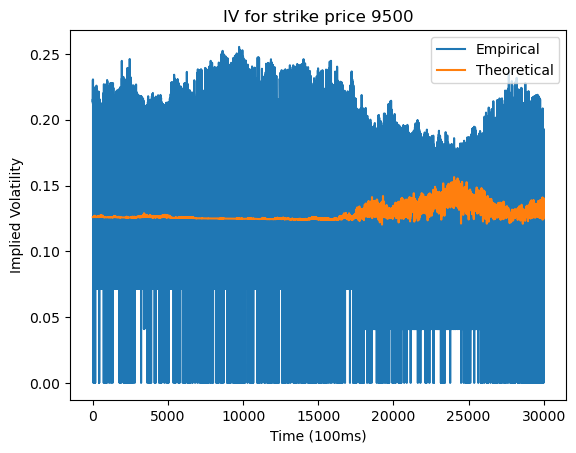

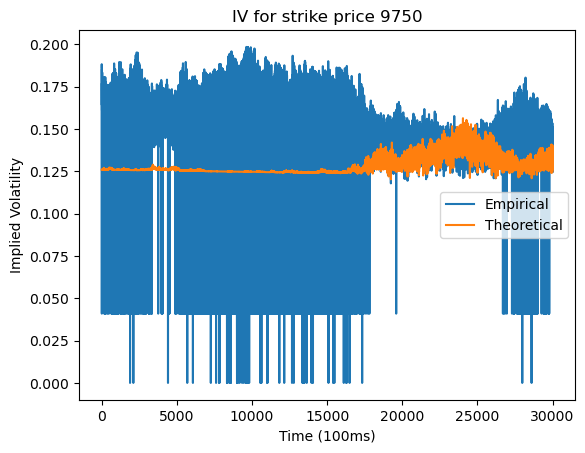

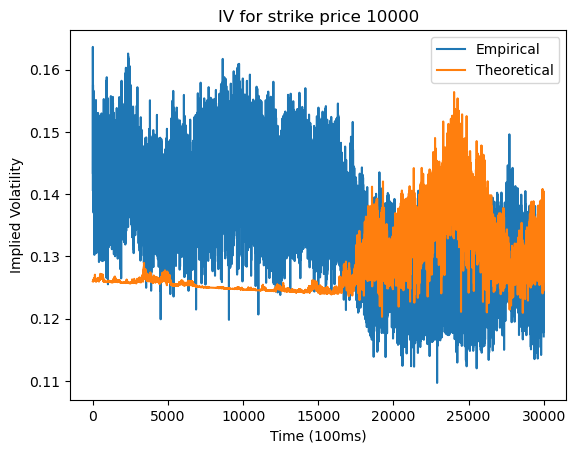

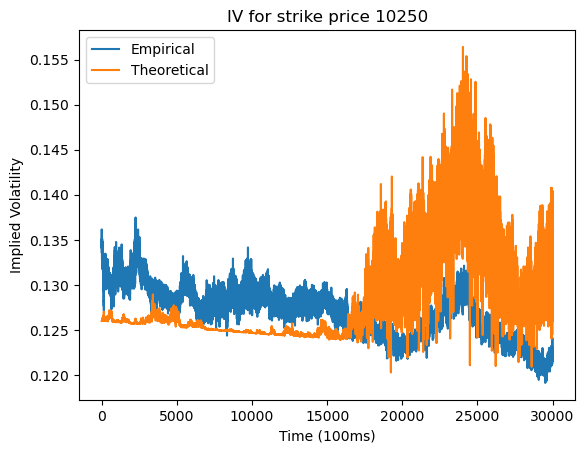

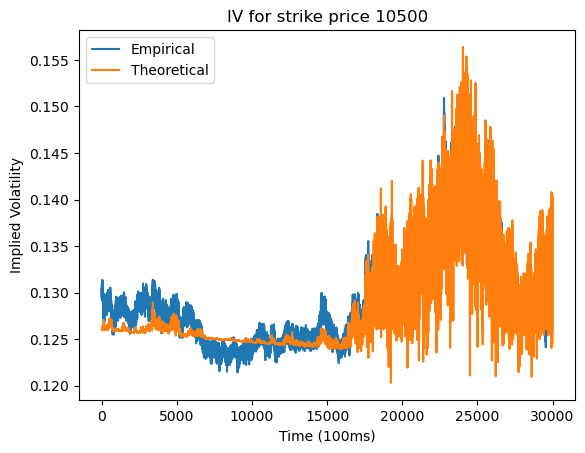

In [43]:
for strike in STRIKES:
    option = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
    fig, ax = plt.subplots()
    ax.plot(option['implied_volatility'], label = "Empirical")
    ax.plot(theo_iv_per_option[strike], label="Theoretical")
    ax.legend()
    ax.set_title("IV for strike price " + str(strike))
    ax.set_xlabel("Time (100ms)")
    ax.set_ylabel("Implied Volatility")
    
    plt.show()

Try using linearly parabolic curve

In [44]:
theo = np.arange(len(df_smile)) * model.coef_[0] + model.intercept_
parabolic_coef = np.arange(len(df_smile)) * coef_model.coef_[0] + coef_model.intercept_
theo_iv_per_option = dict()
for strike in STRIKES:
    x = np.log(strike / spot_price) ** 2 / tte
    theo_iv_per_option[strike] = x2 * parabolic_coef + theo

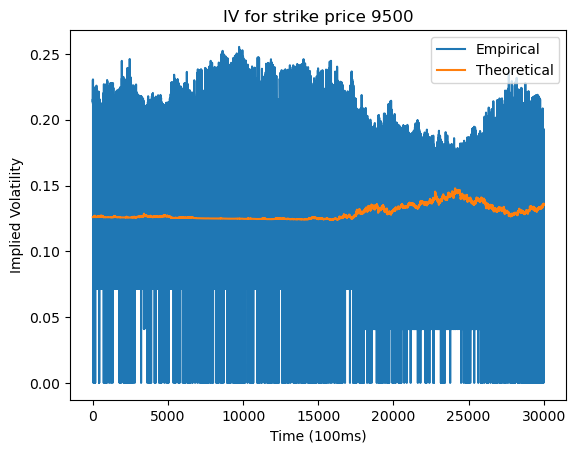

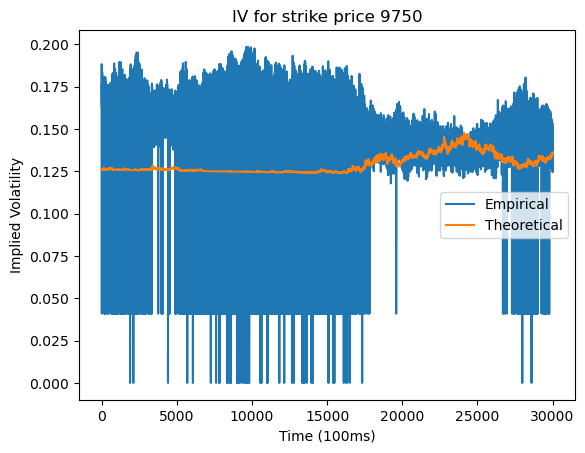

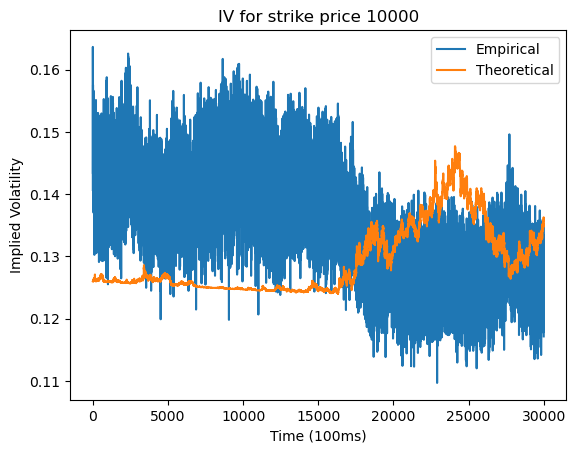

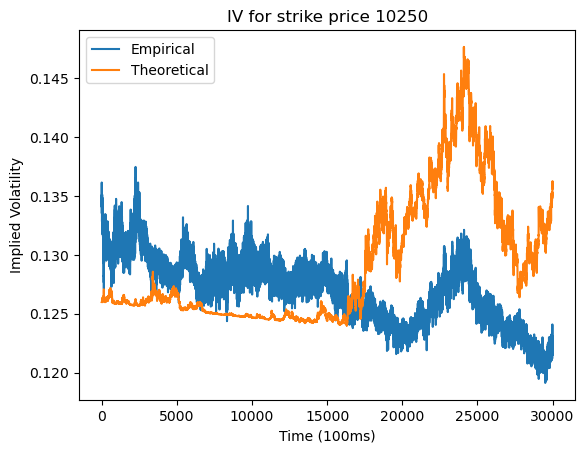

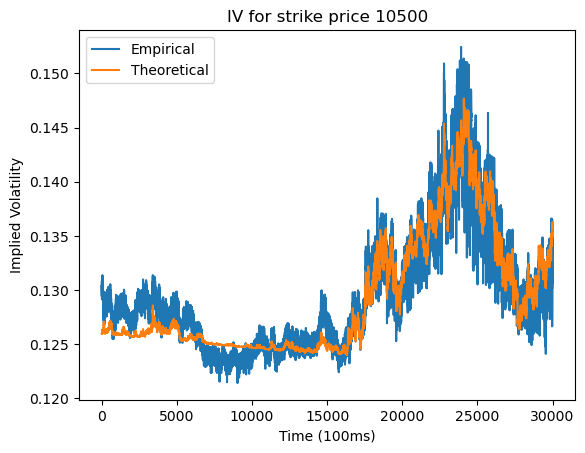

In [45]:
for strike in STRIKES:
    option = pd.read_csv(f"./option_data/VOLCANIC_ROCK_VOUCHER_{strike}.csv", sep=';')
    fig, ax = plt.subplots()
    ax.plot(option['implied_volatility'], label = "Empirical")
    ax.plot(theo_iv_per_option[strike], label="Theoretical")
    ax.legend()
    ax.set_title("IV for strike price " + str(strike))
    ax.set_xlabel("Time (100ms)")
    ax.set_ylabel("Implied Volatility")
    
    plt.show()

Cannot obatain the fair value of IV for 10250 and 10500 because of the error in parabolic curve. The 10250 and 10500 is close to the spot price, leading to higher volatilities in IV.

In [46]:
np.std(spot['mid_price'].pct_change()) / np.sqrt(3 / 250)

0.002284842576189261

In [47]:
option = pd.read_csv("./option_data/VOLCANIC_ROCK_VOUCHER_10000.csv", sep=';')
spot = pd.read_csv("./option_data/VOLCANIC_ROCK.csv", sep=';')
option.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,implied_volatility,delta,gamma,vega
0,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,...,NaN,NaN,NaN,NaN,505.5,0.0,0.140678,0.975161,0.000220,1.092140
1,0,100,VOLCANIC_ROCK_VOUCHER_10000,515.0,13.0,NaN,NaN,NaN,NaN,516,...,NaN,NaN,NaN,NaN,515.5,0.0,0.163655,0.956713,0.000299,1.727163
2,0,200,VOLCANIC_ROCK_VOUCHER_10000,516.0,15.0,NaN,NaN,NaN,NaN,517,...,NaN,NaN,NaN,NaN,516.5,0.0,0.151274,0.968717,0.000248,1.324736
3,0,300,VOLCANIC_ROCK_VOUCHER_10000,521.0,13.0,NaN,NaN,NaN,NaN,522,...,NaN,NaN,NaN,NaN,521.5,0.0,0.155980,0.965792,0.000258,1.426672
4,0,400,VOLCANIC_ROCK_VOUCHER_10000,512.0,15.0,NaN,NaN,NaN,NaN,513,...,NaN,NaN,NaN,NaN,512.5,0.0,0.146514,0.971883,0.000234,1.212076


In [48]:
tte = (TIME_TO_MATURITY - option['day'] - option['timestamp'] / 1000000) / 250

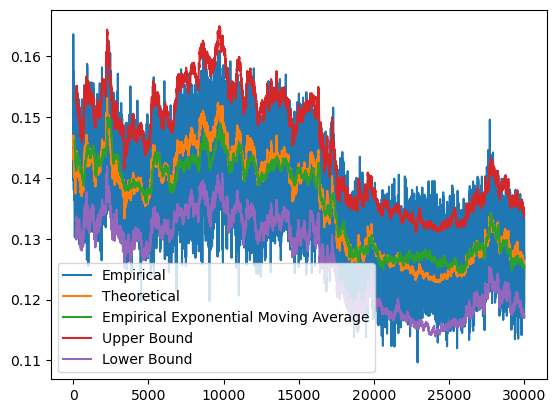

In [49]:
theo = model.coef_[0] * np.arange(len(option)) + model.intercept_[0]
x2 = np.log(10000 / spot['mid_price'].values) ** 2 / tte
theo += x2 * df_smile['parabolic_coef'].mean()

std = option['implied_volatility'].rolling(window=200).std()
thres = 2

plt.plot(option['implied_volatility'], label = "Empirical")
plt.plot(theo, label="Theoretical")
plt.plot(option['implied_volatility'].rolling(100).mean(), label="Empirical Exponential Moving Average")
plt.plot(theo + std * thres, label="Upper Bound")
plt.plot(theo - std * thres, label="Lower Bound")
plt.legend()
plt.show()

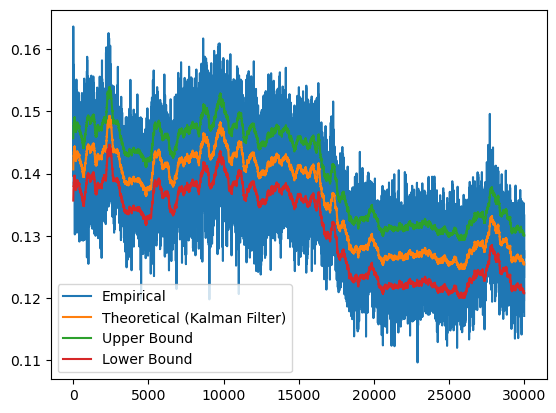

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# 提取观测值
observations = option['implied_volatility'].values

# 初始化卡尔曼滤波器参数
n = len(observations)
state_estimates = np.zeros(n)
state_covariances = np.zeros(n)

# 假设初始状态均值和协方差
state_estimates[0] = observations[0]
state_covariances[0] = 0.000001  # 初始协方差

# 定义过程噪声和测量噪声
process_variance = 1e-8  # 过程噪声方差
measurement_variance = np.var(observations)  # 测量噪声方差

# 卡尔曼滤波器迭代
for t in range(1, n):
    # 预测步骤
    predicted_state = state_estimates[t - 1]
    predicted_covariance = state_covariances[t - 1] + process_variance

    # 更新步骤
    kalman_gain = predicted_covariance / (predicted_covariance + measurement_variance)
    state_estimates[t] = predicted_state + kalman_gain * (observations[t] - predicted_state)
    state_covariances[t] = (1 - kalman_gain) * predicted_covariance

# 计算 theo 和 std
theo = pd.Series(state_estimates, index=option.index)
std = pd.Series(np.sqrt(state_covariances), index=option.index)

# 设置阈值
thres = 5

# 绘图
plt.plot(option['implied_volatility'], label="Empirical")
plt.plot(theo, label="Theoretical (Kalman Filter)")
plt.plot(theo + std * thres, label="Upper Bound")
plt.plot(theo - std * thres, label="Lower Bound")
plt.legend()
plt.show()

<Axes: >

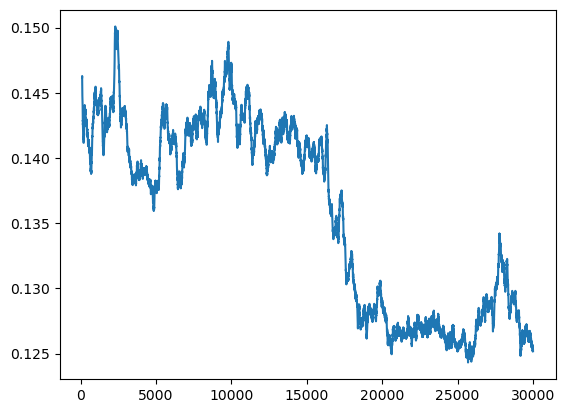

In [51]:
option['implied_volatility'].rolling(window=100).mean().plot()

<Axes: >

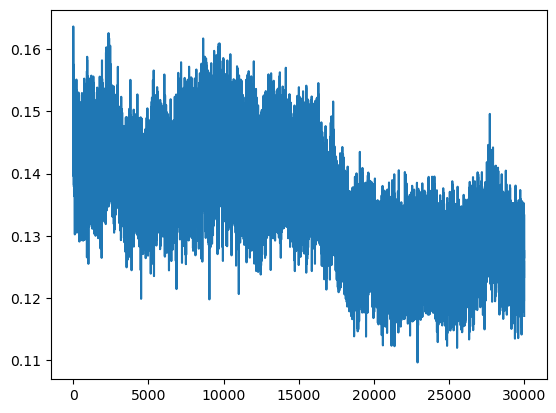

In [52]:
option['implied_volatility'].plot()

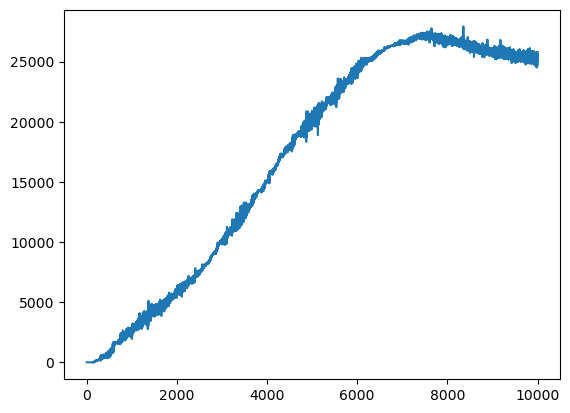

In [11]:
import json
with open("pnl_history_day_2.json", "r") as f:
    pnl_history = json.load(f)
plt.plot(pd.Series(pnl_history['VOLCANIC_ROCK'], dtype=np.float64).ffill().to_numpy() + pd.Series(pnl_history['VOLCANIC_ROCK_VOUCHER_10000'], dtype=np.float64).ffill().to_numpy() + pd.Series(pnl_history['VOLCANIC_ROCK_VOUCHER_10250'], dtype=np.float64).ffill().to_numpy() + pd.Series(pnl_history['VOLCANIC_ROCK_VOUCHER_10500'], dtype=np.float64).ffill().to_numpy())

In [91]:
test = pd.read_csv("./round-3-island-data-bottle/prices_round_3_day_2.csv", sep=';')
test = test[test['product'] == 'VOLCANIC_ROCK_VOUCHER_10000']
new_test = pd.read_csv("../round4_new/round-4-island-data-bottle/prices_round_4_day_2.csv", sep=';')
new_test = new_test[new_test['product'] == 'VOLCANIC_ROCK_VOUCHER_10000']

<Axes: >

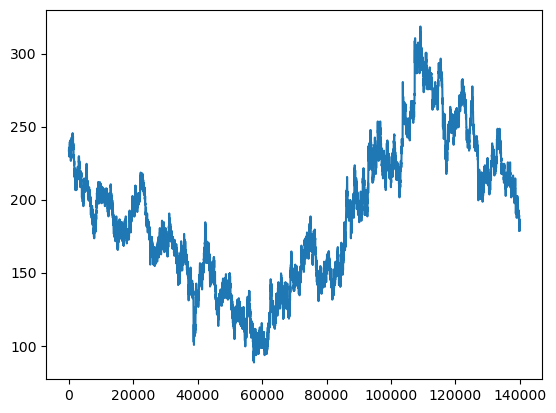

In [93]:
test['mid_price'].plot()

<Axes: >

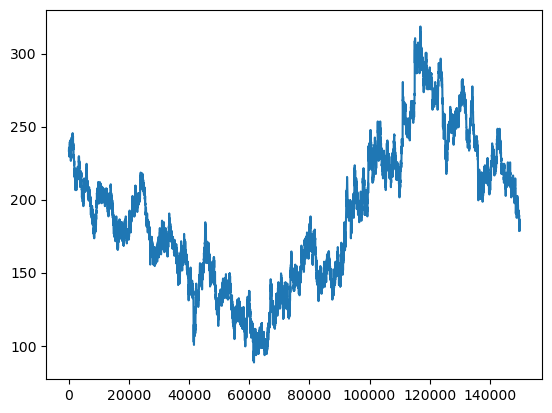

In [94]:
new_test['mid_price'].plot()

In [ ]:
option = pd.read_csv("./option_data/VOLCANIC_ROCK_VOUCHER_10000.csv", sep=';')
spot = pd.read_csv("./option_data/VOLCANIC_ROCK.csv", sep=';')


In [123]:
((spot['bid_price_1'] - 10000) > option['ask_price_1']).sum()

0